# Multi-Class Single-Label classification

The natural extension of binary classification is a multi-class classification task.
We first approach multi-class single-label classification, which makes the assumption that each example is assigned to one and only one label.

We use the Intelliznz data set, which consists of a classification into three mutually-exclusive classes; call these $A(0-50€)$, $B(50-100€)$ and $C(>100€)$.

While one could train three unary predicates $A(x)$, $B(x)$ and $C(x)$, it turns out to be more effective if this problem is modelled by a single binary predicate $P(x,l)$, where $l$ is a variable denoting a multi-class label, in this case classes $A$, $B$ or $C$.
- This syntax allows one to write statements quantifying over the classes, e.g. $\forall x ( \exists l ( P(x,l)))$.
- Since the classes are mutually-exclusive in this case, the output layer of the $\mathtt{MLP}$ representing $P(x,l)$ will be a $\mathtt{softmax}$ layer, instead of a $\mathtt{sigmoid}$ function, to learn the probability of $A$, $B$ and $C$. This avoids writing additional constraints $\lnot (A(x) \land B(x))$, $\lnot (A(x) \land C(x))$, ...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ltn
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os, sys; 
column_path = os.path.dirname(os.path.realpath('C:/Users/sgopalakrish/Downloads/intellizenz-model-training/Neuro-symbolic-AI/column.py'))
if sys.path.__contains__(column_path)==False:
    sys.path.append(column_path)

import column

# Data

Load the Intellizenz dataset: 1.7M samples from each of three classes of veranstaltung segments (0-50€, 50-100€, >100€).

In [3]:
features = column.features_v7
features.append('tarif_bez')

data_path = column.data_path_2016_2020_v4
df = pd.read_parquet(data_path)

le = LabelEncoder()
df['tarif_bez'] = le.fit_transform(df['tarif_bez'])

X = df[features]
y = df['veranst_segment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [4]:
batch_size = 1024
print(y_train)
print(y_test)
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

ID
10982736    0
12875723    0
10305595    0
12425520    2
12917526    0
           ..
12304163    0
11303241    0
13385919    2
11827894    0
13743638    0
Name: veranst_segment, Length: 1393757, dtype: int64
ID
13595945    2
13731961    0
12387244    0
10477201    2
12576779    2
           ..
12052567    2
10722385    2
13376348    1
10259859    0
12962099    2
Name: veranst_segment, Length: 348440, dtype: int64


# LTN

Predicate with softmax `P(x,class)`

In [5]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(16,16,8)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="relu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

logits_model = MLP(4)
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

Constants to index/iterate on the classes

In [6]:
class_A = ltn.Constant(0, trainable=False)
class_B = ltn.Constant(1, trainable=False)
class_C = ltn.Constant(2, trainable=False)

Operators and axioms

In [7]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [8]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.Variable("x_A",features[labels==0])
    x_B = ltn.Variable("x_B",features[labels==1])
    x_C = ltn.Variable("x_C",features[labels==2])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
        Forall(x_C,p([x_C,class_C],training=training))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph

In [9]:
for features, labels in ds_test:
    # print(len(features))
    # print(len(labels==1))
    print(labels==0)
    # print(labels)

    class_a_features = features[labels==0]
    class_b_features = features[labels==0]
    class_c_features = features[labels==0]
    # class_a_features[inex][tarif_index]
    
    # print(fads[0][76])


tf.Tensor([False  True  True ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([ True False False ... False False False], shape=(1024,), dtype=bool)
tf.Tensor([False False  True ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([ True False  True ... False False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ... False  True False], shape=(1024,), dtype=bool)
tf.Tensor([ True False  True ... False  True  True], shape=(1024,), dtype=bool)
tf.Tensor([False  True False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False  True False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ... False False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ...  True  True False], shape=(1024,), dtype=bool)
tf.Tensor([ True False False ...  True False False], shape=(1024,), dtype=bool)
tf.Tensor([False False False ...  True F

In [10]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

Initial sat level 0.19041


# Training

Define the metrics. While training, we measure:
1. The level of satisfiability of the Knowledge Base of the training data.
1. The level of satisfiability of the Knowledge Base of the test data.
3. The training accuracy.
4. The test accuracy.

In [11]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

Define the training and test step

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

Train

In [13]:
import commons

EPOCHS = 500

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    # csv_path="intellizenz_results_v1.csv",
    # csv_path="intellizenz_results_v3.csv",
    csv_path="intellizenz_results_v4.csv",
    track_metrics=20
)

Epoch 0, train_sat_kb: 0.3451, test_sat_kb: 0.4081, train_accuracy: 0.5280, test_accuracy: 0.5304
Epoch 20, train_sat_kb: 0.5582, test_sat_kb: 0.5601, train_accuracy: 0.7631, test_accuracy: 0.7671
Epoch 40, train_sat_kb: 0.5573, test_sat_kb: 0.5580, train_accuracy: 0.7602, test_accuracy: 0.7586
Epoch 60, train_sat_kb: 0.5615, test_sat_kb: 0.5624, train_accuracy: 0.7657, test_accuracy: 0.7647
Epoch 80, train_sat_kb: 0.5622, test_sat_kb: 0.5497, train_accuracy: 0.7645, test_accuracy: 0.7538
Epoch 100, train_sat_kb: 0.5626, test_sat_kb: 0.5626, train_accuracy: 0.7652, test_accuracy: 0.7617
Epoch 120, train_sat_kb: 0.5619, test_sat_kb: 0.5596, train_accuracy: 0.7638, test_accuracy: 0.7595
Epoch 140, train_sat_kb: 0.5623, test_sat_kb: 0.5701, train_accuracy: 0.7676, test_accuracy: 0.7754
Epoch 160, train_sat_kb: 0.5637, test_sat_kb: 0.5614, train_accuracy: 0.7669, test_accuracy: 0.7653
Epoch 180, train_sat_kb: 0.5625, test_sat_kb: 0.5698, train_accuracy: 0.7680, test_accuracy: 0.7763
Epoch 

## Save the trained model

In [14]:
# Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)


# # Save the weights using the `checkpoint_path` format
# logits_model.save_weights(checkpoint_path.format(epoch=0))

# Save the weights
logits_model.save_weights('./checkpoints/d1.7m_loote_500ep.ckpt')


## Load the model

In [16]:
# Create a new model instance
model = MLP(4)

# Restore the weights
model.load_weights('./checkpoints/d1.7m_loote_500ep.ckpt')


## Plot Satisfiability and Accuracy

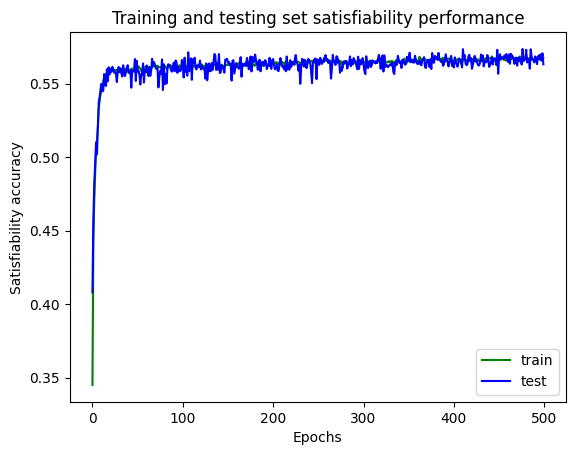

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# file = pd.read_csv('intellizenz_results_v1.csv')
# file = pd.read_csv('intellizenz_results_v2.csv')
file = pd.read_csv('intellizenz_results_v4.csv')


sat_train_acc = file['train_sat_kb']
sat_test_acc = file['test_sat_kb']

train_acc = file['train_accuracy']
test_acc = file['test_accuracy']

epochs = file['Epoch']

plt.plot(epochs, sat_train_acc, 'g', label='train')
plt.plot(epochs, sat_test_acc, 'b', label='test')
plt.title('Training and testing set satisfiability performance')
plt.xlabel('Epochs')
plt.ylabel('Satisfiability accuracy')
plt.legend()
plt.show()

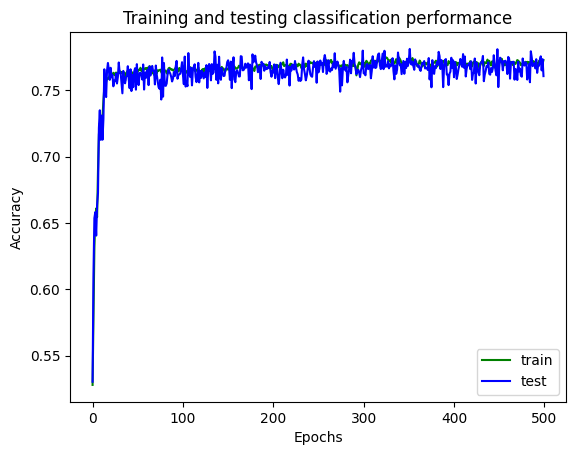

In [19]:
plt.plot(epochs, train_acc, 'g', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
plt.title('Training and testing classification performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()